In [38]:
!pip install geopandas


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:

from __future__ import annotations
import os, gc, math, json, re, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import geopandas as gpd
import matplotlib.pyplot as plt
from typing import List, Optional
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


In [52]:
DATA_DIR = Path(r"C:\Users\janen\Desktop\GEOAI Challenge for Cropland Mapping in Dry Environments\data")
CACHE_DIR = Path("./cache")      
OUT_DIR = Path("./out")    
for d in [CACHE_DIR, OUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)

TRAIN_ZIP = DATA_DIR / "Train.zip"
TRAIN_CSV = DATA_DIR / "Train.csv"
TEST_CSV = DATA_DIR / "Test.csv"
S1_CSV = DATA_DIR / "Sentinel1.csv"
S2_CSV = DATA_DIR / "Sentinel2.csv"

S1_PARQ = CACHE_DIR / "s1.parquet"
S2_PARQ = CACHE_DIR / "s2.parquet"
TRAIN_PARQ = CACHE_DIR / "train.parquet"
TEST_PARQ = CACHE_DIR / "test.parquet"

SEED = 42
N_FOLDS = 5
DTYPE_FLOAT32 = np.float32

np.random.seed(SEED)

In [ ]:
# 🚩 Build crosswalk between shapefile numeric IDs and S1 string IDs using geometry
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

FERG = DATA_DIR / "train" / "Fergana_training_samples.shp"
OREN = DATA_DIR / "train" / "Orenburg_training_samples.shp"

# 1) Load shapefiles, keep numeric ID + geometry
def load_shp_points(path):
    gdf = gpd.read_file(path)
    # assume "ID" = numeric, "Cropland" = target (adjust if needed)
    cols = {c.lower(): c for c in gdf.columns}
    id_col = cols.get("id")
    tgt_col = cols.get("cropland") or cols.get("target") or cols.get("label") or cols.get("class")
    if id_col is None or tgt_col is None:
        raise ValueError(f"{path.name}: expected 'ID' and a label column (e.g., 'Cropland'). Found: {list(gdf.columns)}")
    gdf = gdf[[id_col, tgt_col, "geometry"]].rename(columns={id_col: "ID_num", tgt_col: "Target"})
    # target to 0/1
    mapping = {"cropland":1, "crop":1, "1":1, 1:1, True:1,
               "noncropland":0, "non-cropland":0, "pasture":0, "steppe":0, "0":0, 0:0, False:0}
    gdf["Target"] = gdf["Target"].map(lambda x: mapping.get(x, mapping.get(str(x).strip().lower(), np.nan)))
    if gdf["Target"].isna().any():
        print("⚠️ Unmapped labels in", path.name, gdf[gdf["Target"].isna()].head())
    gdf["region"] = path.stem.split("_")[0]  # "Fergana" / "Orenburg"
    return gdf

gdf_train = pd.concat([load_shp_points(FERG), load_shp_points(OREN)], ignore_index=True)
gdf_train = gdf_train.dropna(subset=["Target"])

# Ensure WGS84
if gdf_train.crs is None:
    gdf_train = gdf_train.set_crs(4326)
else:
    gdf_train = gdf_train.to_crs(4326)

# 2) Build GeoDF of S1 centroids per string ID
#    We already aggregated S1 to per-ID features (s1_feats). Extract centroid columns.
needed = ["ID", "translated_lat__mean", "translated_lon__mean"]
miss = [c for c in needed if c not in s1_feats.columns]
if miss:
    raise ValueError(f"S1 features missing columns: {miss}")

df_cent = s1_feats[needed].dropna().copy()
df_cent["ID_str"] = df_cent["ID"].astype(str)
geom = [Point(lon, lat) for lat, lon in zip(df_cent["translated_lat__mean"], df_cent["translated_lon__mean"])]
gdf_cent = gpd.GeoDataFrame(df_cent[["ID_str"]], geometry=geom, crs=4326)

# 3) Project to a metric CRS for sensible matching distances (UTM auto per centroid)
#    We'll use EPSG:3857 (meters) for a quick, region-agnostic distance.
gdf_train_m = gdf_train.to_crs(3857)
gdf_cent_m  = gdf_cent.to_crs(3857)

# 4) Spatial nearest join: for each S1 ID_str, find the nearest shapefile point
nearest = gpd.sjoin_nearest(
    gdf_cent_m[["ID_str", "geometry"]],
    gdf_train_m[["ID_num", "Target", "region", "geometry"]],
    how="left",
    distance_col="dist_m",
)

# 5) (Optional) filter insane matches (e.g., > 5 km) — adjust threshold as needed
MAX_DIST_M = 5000  # 5 km
bad = nearest[nearest["dist_m"] > MAX_DIST_M]
if len(bad):
    print(f"⚠️ {len(bad)} S1 IDs matched > {MAX_DIST_M/1000:.1f} km away. You may increase threshold or inspect them.")
nearest_ok = nearest[nearest["dist_m"] <= MAX_DIST_M].copy()

# 6) Build crosswalk and aligned labels with string IDs
crosswalk = nearest_ok[["ID_str", "ID_num", "dist_m", "Target", "region"]].drop_duplicates("ID_str")
print("Crosswalk rows:", len(crosswalk))
display(crosswalk.head())

# 7) Create Train_aligned with string IDs (ID_XXXXXX) and correct Target
train_aligned = crosswalk[["ID_str", "Target"]].rename(columns={"ID_str":"ID"}).copy()
train_aligned["ID"] = train_aligned["ID"].astype(str)
train_aligned["Target"] = train_aligned["Target"].astype(int)

# Save aligned labels so downstream joins work
aligned_csv  = DATA_DIR / "Train_aligned.csv"
aligned_parq = CACHE_DIR / "train_aligned.parquet"
train_aligned.to_csv(aligned_csv, index=False)
train_aligned.to_parquet(aligned_parq, index=False)
print("✅ Wrote aligned labels:", aligned_csv, train_aligned.shape)

Found existing Train.csv → skipping shapefile conversion.


,ID,Target
0,1,0
1,2,0
2,3,1
3,4,0
4,5,0


In [42]:

#@title 🧾 Load Test.csv & cache Train/Test to Parquet
if not TEST_CSV.exists():
    raise SystemExit("Test.csv not found. Place it next to this notebook or update DATA_DIR.")

test_df = pd.read_csv(TEST_CSV)
print("Test shape:", test_df.shape)
train_df.to_parquet(TRAIN_PARQ, index=False)
test_df.to_parquet(TEST_PARQ, index=False)
display(test_df.head())


Test shape: (600, 4)


,ID,location,translated_lat,translated_lon
0,ID_QAHFTR,Fergana,41.464538,71.767177
1,ID_XCKAFN,Fergana,41.081855,72.397795
2,ID_AFQOFP,Fergana,41.652106,72.144470
3,ID_VAUSIE,Fergana,41.366980,73.032185
4,ID_YICCWP,Fergana,41.334641,71.520590


In [43]:

#@title 🛰️ Convert Sentinel CSVs → Parquet (first run only)
TIME_CANDIDATES = ["timestamp","time","date","acq_time","scene_time"]
S1_BANDS = {"VV","VH","HH","HV"}
S2_BAND_RE = re.compile(r"^B(\d{1,2}[A]?)$", re.IGNORECASE)

def detect_columns(df: pd.DataFrame):
    time_col = next((c for c in TIME_CANDIDATES if c in df.columns), None)
    id_col = next((c for c in ["ID","id","Id"] if c in df.columns), None)
    s2_bands = [c for c in df.columns if S2_BAND_RE.match(c)]
    s1_bands = [c for c in df.columns if c.upper() in S1_BANDS]
    return id_col, time_col, s1_bands, s2_bands

def to_parquet_cached(csv_path: Path, parq_path: Path, label: str):
    if parq_path.exists():
        print(f"✅ Using cached {label}:", parq_path)
        return
    if not csv_path.exists():
        print(f"⚠️ {csv_path.name} not found, skipping.")
        return
    print(f"🔄 Converting {csv_path.name} → Parquet …")
    reader = pd.read_csv(csv_path, chunksize=500_000)
    out_parts = []
    for i, ch in enumerate(reader, 1):
        id_col, time_col, _, _ = detect_columns(ch)
        if id_col is None:
            raise ValueError(f"ID column not found in {csv_path.name}")
        # downcast numbers
        for c in ch.select_dtypes(include=["float64","float32","int64","int32"]).columns:
            ch[c] = pd.to_numeric(ch[c], errors="coerce").astype(DTYPE_FLOAT32)
        # parse time
        if time_col is not None and not np.issubdtype(ch[time_col].dtype, np.datetime64):
            ch[time_col] = pd.to_datetime(ch[time_col], errors="coerce")
        part = CACHE_DIR / f"{parq_path.stem}_part{i:03d}.parquet"
        ch.to_parquet(part, index=False)
        out_parts.append(part)
        print(f"  → wrote {part.name} ({len(ch)} rows)")
    # concatenate
    lf = pl.concat([pl.scan_parquet(str(p)) for p in out_parts])
    lf.sink_parquet(str(parq_path))
    for p in out_parts:
        p.unlink(missing_ok=True)
    print(f"Done: {parq_path}")

to_parquet_cached(S1_CSV, S1_PARQ, "S1")
to_parquet_cached(S2_CSV, S2_PARQ, "S2")


✅ Using cached S1: cache\s1.parquet
✅ Using cached S2: cache\s2.parquet


In [44]:
#@title 🧪 Feature Engineering (NDVI/EVI, VV/VH, stats, trends, FFT) — CLEANED
def safe_ratio(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a / b.replace(0, np.nan)).fillna(0)

def add_ndvi(df: pd.DataFrame, bands: List[str]) -> Optional[pd.Series]:
    b8 = next((c for c in ["B8","B08"] if c in bands), None)
    b4 = next((c for c in ["B4","B04"] if c in bands), None)
    if b8 and b4:
        return safe_ratio(df[b8] - df[b4], df[b8] + df[b4])
    return None

def add_evi(df: pd.DataFrame, bands: List[str]) -> Optional[pd.Series]:
    mapping = {}
    for k, ks in {"nir":["B8","B08"], "red":["B4","B04"], "blue":["B2","B02"]}.items():
        mapping[k] = next((c for c in ks if c in bands), None)
    if all(mapping.values()):
        nir, red, blue = mapping["nir"], mapping["red"], mapping["blue"]
        num = df[nir] - df[red]
        den = df[nir] + 6*df[red] - 7.5*df[blue] + 1.0
        return 2.5 * safe_ratio(num, den)
    return None

def seasonal_bins(dt: pd.Series) -> pd.Series:
    # expects datetime-like series
    m = dt.dt.month
    return pd.cut(m, bins=[0,3,6,9,12], labels=["Q1","Q2","Q3","Q4"], include_lowest=True)

def fft_energy(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=np.float32)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return 0.0
    f = np.fft.rfft(x - x.mean())
    power = (f * np.conj(f)).real
    return float(power[1:].sum())  # drop DC component

def per_id_features(df: pd.DataFrame, id_col: str, time_col: Optional[str]) -> pd.DataFrame:
    # Detect sensor bands
    _, _, s1_bands, s2_bands = detect_columns(df)

    # Numeric columns to aggregate (exclude id/time/object)
    num_cols = [c for c in df.columns
                if c not in [id_col, time_col] and df[c].dtype != "O"]

    d = df.copy()

    # Derived indices
    if s2_bands:
        ndvi = add_ndvi(d, s2_bands)
        if ndvi is not None:
            d["NDVI"] = ndvi.astype(DTYPE_FLOAT32); num_cols.append("NDVI")
        evi = add_evi(d, s2_bands)
        if evi is not None:
            d["EVI"] = evi.astype(DTYPE_FLOAT32); num_cols.append("EVI")
    if s1_bands and ("VV" in d.columns) and ("VH" in d.columns):
        d["VV_VH"] = safe_ratio(d["VV"], d["VH"]).astype(DTYPE_FLOAT32)
        num_cols.append("VV_VH")

    # If nothing numeric, return ID-only frame
    if not num_cols:
        return d[[id_col]].drop_duplicates().reset_index(drop=True)

    # Seasonal bins (if time available)
    if time_col is not None and time_col in d.columns:
        d[time_col] = pd.to_datetime(d[time_col], errors="coerce")
        d["_season"] = seasonal_bins(d[time_col])
    else:
        d["_season"] = "ALL"

    feats = []

    # Overall stats per ID
    agg_funcs = ["mean", "std", "min", "max", "median"]
    overall = d.groupby(id_col, dropna=True)[num_cols].agg(agg_funcs)
    overall.columns = [f"{a}__{b}" for a, b in overall.columns]
    feats.append(overall)

    # Seasonal stats (feature, agg, season) → "feature__agg__season"
    try:
        seasonal = (
            d.groupby([id_col, "_season"], dropna=True, observed=False)[num_cols]
             .agg(["mean", "median"])
             .unstack("_season")
             .sort_index(axis=1)
        )
        seasonal.columns = [
            "__".join([str(x) for x in col if x is not None and str(x) != ""])
            for col in seasonal.columns.to_flat_index()
        ]
        feats.append(seasonal)
    except Exception:
        # If grouping/unstacking fails (e.g., all seasons NaN), skip seasonal features
        pass

    # Trend slopes & FFT energy (if time available)
    if time_col is not None and time_col in d.columns:
        d = d.sort_values([id_col, time_col])
        # safe time → int seconds
        t_sec = d[time_col].astype("int64") / 1e9
        d["_t"] = t_sec

        # Slopes (select only the needed columns to avoid DeprecationWarning)
        slopes = {}
        for col in num_cols:
            grp = d[[id_col, "_t", col]].dropna()
            def slope_fn(sub):
                x = sub["_t"].values.astype(np.float64)
                y = sub[col].values.astype(np.float64)
                if x.size < 3:
                    return 0.0
                x = x - x.mean()
                denom = (x * x).sum()
                if denom <= 0:
                    return 0.0
                return float((x * y).sum() / denom)
            slopes[col] = grp.groupby(id_col, dropna=True)[["_t", col]].apply(slope_fn)
        if slopes:
            slopes_df = pd.DataFrame(slopes)
            slopes_df.columns = [f"{c}__slope" for c in slopes_df.columns]
            feats.append(slopes_df)

        # FFT energy
        energies = {}
        for col in num_cols:
            def e_fn(sub): return fft_energy(sub[col].values)
            energies[col] = d[[id_col, col]].groupby(id_col, dropna=True)[[col]].apply(e_fn)
        if energies:
            e_df = pd.DataFrame(energies)
            e_df.columns = [f"{c}__fft_energy" for c in e_df.columns]
            feats.append(e_df)

    # Counts of valid observations
    counts = d.groupby(id_col, dropna=True)[num_cols].count()
    counts.columns = [f"{c}__count" for c in counts.columns]
    feats.append(counts)

    # Combine + clean
    feat_df = pd.concat(feats, axis=1)
    feat_df = feat_df.replace([np.inf, -np.inf], np.nan).fillna(0).astype(DTYPE_FLOAT32)
    return feat_df.reset_index()

def build_features_from_parquet(parq_path: Path) -> Optional[pd.DataFrame]:
    if not parq_path.exists():
        print("Missing parquet:", parq_path)
        return None
    lf = pl.scan_parquet(str(parq_path))
    head = lf.head(5).collect().to_pandas()
    id_col, time_col, _, _ = detect_columns(head)
    if id_col is None:
        raise ValueError(f"ID not found in {parq_path}")
    df = lf.collect().to_pandas()
    feats = per_id_features(df, id_col=id_col, time_col=time_col)
    return feats

# Build S1/S2 feature tables
s1_feats = build_features_from_parquet(S1_PARQ)
s2_feats = build_features_from_parquet(S2_PARQ)
print("S1 features:", None if s1_feats is None else s1_feats.shape)
print("S2 features:", None if s2_feats is None else s2_feats.shape)

S1 features: (600, 97)
S2 features: (600, 273)


In [45]:
# 🚩 Build crosswalk between shapefile numeric IDs and S1 string IDs using geometry
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

FERG = DATA_DIR / "train" / "Fergana_training_samples.shp"
OREN = DATA_DIR / "train" / "Orenburg_training_samples.shp"

# 1) Load shapefiles, keep numeric ID + geometry
def load_shp_points(path):
    gdf = gpd.read_file(path)
    # assume "ID" = numeric, "Cropland" = target (adjust if needed)
    cols = {c.lower(): c for c in gdf.columns}
    id_col = cols.get("id")
    tgt_col = cols.get("cropland") or cols.get("target") or cols.get("label") or cols.get("class")
    if id_col is None or tgt_col is None:
        raise ValueError(f"{path.name}: expected 'ID' and a label column (e.g., 'Cropland'). Found: {list(gdf.columns)}")
    gdf = gdf[[id_col, tgt_col, "geometry"]].rename(columns={id_col: "ID_num", tgt_col: "Target"})
    # target to 0/1
    mapping = {"cropland":1, "crop":1, "1":1, 1:1, True:1,
               "noncropland":0, "non-cropland":0, "pasture":0, "steppe":0, "0":0, 0:0, False:0}
    gdf["Target"] = gdf["Target"].map(lambda x: mapping.get(x, mapping.get(str(x).strip().lower(), np.nan)))
    if gdf["Target"].isna().any():
        print("⚠️ Unmapped labels in", path.name, gdf[gdf["Target"].isna()].head())
    gdf["region"] = path.stem.split("_")[0]  # "Fergana" / "Orenburg"
    return gdf

gdf_train = pd.concat([load_shp_points(FERG), load_shp_points(OREN)], ignore_index=True)
gdf_train = gdf_train.dropna(subset=["Target"])

# Ensure WGS84
if gdf_train.crs is None:
    gdf_train = gdf_train.set_crs(4326)
else:
    gdf_train = gdf_train.to_crs(4326)

# 2) Build GeoDF of S1 centroids per string ID
#    We already aggregated S1 to per-ID features (s1_feats). Extract centroid columns.
needed = ["ID", "translated_lat__mean", "translated_lon__mean"]
miss = [c for c in needed if c not in s1_feats.columns]
if miss:
    raise ValueError(f"S1 features missing columns: {miss}")

df_cent = s1_feats[needed].dropna().copy()
df_cent["ID_str"] = df_cent["ID"].astype(str)
geom = [Point(lon, lat) for lat, lon in zip(df_cent["translated_lat__mean"], df_cent["translated_lon__mean"])]
gdf_cent = gpd.GeoDataFrame(df_cent[["ID_str"]], geometry=geom, crs=4326)

# 3) Project to a metric CRS for sensible matching distances (UTM auto per centroid)
#    We'll use EPSG:3857 (meters) for a quick, region-agnostic distance.
gdf_train_m = gdf_train.to_crs(3857)
gdf_cent_m  = gdf_cent.to_crs(3857)

# 4) Spatial nearest join: for each S1 ID_str, find the nearest shapefile point
nearest = gpd.sjoin_nearest(
    gdf_cent_m[["ID_str", "geometry"]],
    gdf_train_m[["ID_num", "Target", "region", "geometry"]],
    how="left",
    distance_col="dist_m",
)

# 5) (Optional) filter insane matches (e.g., > 5 km) — adjust threshold as needed
MAX_DIST_M = 5000  # 5 km
bad = nearest[nearest["dist_m"] > MAX_DIST_M]
if len(bad):
    print(f"⚠️ {len(bad)} S1 IDs matched > {MAX_DIST_M/1000:.1f} km away. You may increase threshold or inspect them.")
nearest_ok = nearest[nearest["dist_m"] <= MAX_DIST_M].copy()

# 6) Build crosswalk and aligned labels with string IDs
crosswalk = nearest_ok[["ID_str", "ID_num", "dist_m", "Target", "region"]].drop_duplicates("ID_str")
print("Crosswalk rows:", len(crosswalk))
display(crosswalk.head())

# 7) Create Train_aligned with string IDs (ID_XXXXXX) and correct Target
train_aligned = crosswalk[["ID_str", "Target"]].rename(columns={"ID_str":"ID"}).copy()
train_aligned["ID"] = train_aligned["ID"].astype(str)
train_aligned["Target"] = train_aligned["Target"].astype(int)

# Save aligned labels so downstream joins work
aligned_csv  = DATA_DIR / "Train_aligned.csv"
aligned_parq = CACHE_DIR / "train_aligned.parquet"
train_aligned.to_csv(aligned_csv, index=False)
train_aligned.to_parquet(aligned_parq, index=False)
print("✅ Wrote aligned labels:", aligned_csv, train_aligned.shape)

⚠️ 364 S1 IDs matched > 5.0 km away. You may increase threshold or inspect them.
Crosswalk rows: 236


,ID_str,ID_num,dist_m,Target,region
0,ID_ABQOQT,243,3171.600260,0,Fergana
2,ID_AFIWZH,464,3080.380858,1,Fergana
4,ID_AHRONV,216,4105.332379,0,Orenburg
6,ID_ALPHGS,148,1502.968649,0,Fergana
7,ID_ANJQRQ,107,1567.760372,0,Orenburg


✅ Wrote aligned labels: C:\Users\janen\Desktop\GEOAI Challenge for Cropland Mapping in Dry Environments\data\Train_aligned.csv (236, 2)


In [46]:
#@title 🔗 Join features to Train/Test IDs — dtype-safe, numeric-only cleaning
from typing import Optional

def _find_id_key(df: pd.DataFrame) -> Optional[str]:
    for k in ["ID", "id", "Id"]:
        if k in df.columns:
            return k
    return None

def _coerce_id_to_str(df: pd.DataFrame, key: str) -> pd.DataFrame:
    out = df.copy()
    out[key] = out[key].astype(str).str.strip()
    return out

def join_feats(ids_df: pd.DataFrame, *feat_tables: Optional[pd.DataFrame]) -> pd.DataFrame:
    """
    Merges any number of feature tables onto ids_df using the ID key.
    - Forces all ID columns to string for safe merges
    - Drops duplicate IDs in feature tables
    - Only fills/casts numeric columns (leaves text columns like 'location' intact)
    """
    if ids_df is None or len(ids_df) == 0:
        raise ValueError("ids_df is empty")

    out = ids_df.copy()
    key = _find_id_key(out)
    if key is None:
        raise ValueError("ID column not found in ids_df")

    # Ensure ID is string
    out = _coerce_id_to_str(out, key)

    # Merge all feature tables
    for ft in feat_tables:
        if ft is None or len(ft) == 0:
            continue
        fk = _find_id_key(ft)
        if fk is None:
            raise ValueError("ID column not found in a feature table")

        ft2 = _coerce_id_to_str(ft, fk).drop_duplicates(subset=[fk])
        out = out.merge(ft2, left_on=key, right_on=fk, how="left", suffixes=("", "_dup"))

        # remove extra key if names differ
        if fk != key and fk in out.columns:
            out = out.drop(columns=[fk])

        # paranoia: drop any accidental *_dup columns
        dup_cols = [c for c in out.columns if c.endswith("_dup")]
        if dup_cols:
            out = out.drop(columns=dup_cols)

    # Clean ONLY numeric columns (leave text like 'location' alone)
    exclude = {key, "Target", "target"}
    candidate_cols = [c for c in out.columns if c not in exclude]
    num_cols = out[candidate_cols].select_dtypes(include=[np.number]).columns.tolist()

    if num_cols:
        out[num_cols] = (
            out[num_cols]
            .replace([np.inf, -np.inf], np.nan)
            .fillna(0)
            .astype(DTYPE_FLOAT32)
        )

    return out

# --- Load cached Train/Test and join ---
test_df  = pd.read_parquet(TEST_PARQ)
train_df = pd.read_parquet(TRAIN_PARQ)

X_train = join_feats(train_df, s1_feats, s2_feats)
X_test  = join_feats(test_df,  s1_feats, s2_feats)

print("Joined train:", X_train.shape)
print("Joined test :", X_test.shape)
display(X_train.head())

Joined train: (500, 338)
Joined test : (600, 340)


,ID,Target,VH__mean,VH__std,VH__min,VH__max,VH__median,VV__mean,VV__std,VV__min,...,B5__count,B6__count,B7__count,B8__count,B8A__count,cloud_pct__count,solar_azimuth__count,solar_zenith__count,NDVI__count,EVI__count
0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
# Use the aligned labels (string IDs)
train_df = pd.read_parquet(CACHE_DIR / "train_aligned.parquet")
test_df  = pd.read_parquet(TEST_PARQ)  # your test IDs are already string-like (ID_XXXXXX)

X_train = join_feats(train_df, s1_feats, s2_feats)
X_test  = join_feats(test_df,  s1_feats, s2_feats)

print("Joined train:", X_train.shape)
print("Joined test :", X_test.shape)

# Quick sanity checks (should be non-zero for many rows now)
for col in ["VH__mean","VV__mean","B11__mean","NDVI__mean","EVI__mean"]:
    if col in X_train.columns:
        print(col, "non-zero rows:", int((X_train[col] != 0).sum()))


Joined train: (236, 338)
Joined test : (600, 340)
VH__mean non-zero rows: 236
VV__mean non-zero rows: 236
B11__mean non-zero rows: 236
NDVI__mean non-zero rows: 236
EVI__mean non-zero rows: 236


In [48]:
X_train.to_csv("train_n.csv", index=False)
X_test.to_csv("test_n.csv", index=False)

In [49]:

#@title 🤖 Baselines (Accuracy, Stratified K-Fold)
TARGET_COL = "Target" if "Target" in X_train.columns else "target"
features = [c for c in X_train.columns if c not in ["ID","id", TARGET_COL]]
id_col = "ID" if "ID" in X_train.columns else "id"

y = X_train[TARGET_COL].astype(int).values
X = X_train[features].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def run_lgbm():
    accs = []; oof = np.zeros(len(X))
    for fold, (tr, va) in enumerate(cv.split(X, y), 1):
        dtrain = lgb.Dataset(X[tr], label=y[tr])
        dvalid = lgb.Dataset(X[va], label=y[va], reference=dtrain)
        params = dict(objective="binary", metric="binary_logloss", learning_rate=0.05,
                      num_leaves=31, feature_fraction=0.8, bagging_fraction=0.8,
                      bagging_freq=1, min_data_in_leaf=50, verbose=-1, seed=SEED+fold)
        model = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=[dvalid],
                          valid_names=["val"], callbacks=[lgb.early_stopping(50, verbose=False)])
        proba = model.predict(X[va], num_iteration=model.best_iteration)
        oof[va] = proba
        preds = (proba >= 0.5).astype(int)
        acc = accuracy_score(y[va], preds)
        accs.append(acc); print(f"[LGBM] fold {fold} acc: {acc:.4f}")
    print(f"[LGBM] CV mean acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    return oof

def run_cat():
    accs = []; oof = np.zeros(len(X))
    for fold, (tr, va) in enumerate(cv.split(X, y), 1):
        model = CatBoostClassifier(loss_function="Logloss", depth=6, learning_rate=0.05,
                                   iterations=1000, l2_leaf_reg=3.0, random_seed=SEED+fold,
                                   verbose=False, od_type="Iter", od_wait=50)
        model.fit(X[tr], y[tr], eval_set=(X[va], y[va]), verbose=False)
        proba = model.predict_proba(X[va])[:,1]; oof[va] = proba
        preds = (proba >= 0.5).astype(int)
        acc = accuracy_score(y[va], preds)
        accs.append(acc); print(f"[CatBoost] fold {fold} acc: {acc:.4f}")
    print(f"[CatBoost] CV mean acc: {np.mean(accs):.4f} ± {np.std(accs):.4f}")
    return oof

oof_lgbm = run_lgbm()
oof_cat  = run_cat()
blend = 0.5*oof_lgbm + 0.5*oof_cat
print("[Blend] CV Accuracy:", accuracy_score(y, (blend>=0.5).astype(int)))


[LGBM] fold 1 acc: 0.6667
[LGBM] fold 2 acc: 0.7234
[LGBM] fold 3 acc: 0.7234
[LGBM] fold 4 acc: 0.6170
[LGBM] fold 5 acc: 0.5745
[LGBM] CV mean acc: 0.6610 ± 0.0587
[CatBoost] fold 1 acc: 0.6250
[CatBoost] fold 2 acc: 0.7447
[CatBoost] fold 3 acc: 0.6170
[CatBoost] fold 4 acc: 0.7447
[CatBoost] fold 5 acc: 0.6170
[CatBoost] CV mean acc: 0.6697 ± 0.0613
[Blend] CV Accuracy: 0.6949152542372882


In [50]:

#@title 🚀 Train full models & create submission.csv
def fit_full_lgbm(X, y):
    dtrain = lgb.Dataset(X, label=y)
    params = dict(objective="binary", metric="binary_logloss", learning_rate=0.05,
                  num_leaves=31, feature_fraction=0.8, bagging_fraction=0.8,
                  bagging_freq=1, min_data_in_leaf=50, verbose=-1, seed=SEED)
    return lgb.train(params, dtrain, num_boost_round=int(1.2*1000))

def fit_full_cat(X, y):
    model = CatBoostClassifier(loss_function="Logloss", depth=6, learning_rate=0.05,
                               iterations=int(1.2*1000), l2_leaf_reg=3.0,
                               random_seed=SEED, verbose=False)
    model.fit(X, y); return model

lgbm_full = fit_full_lgbm(X, y)
cat_full  = fit_full_cat(X, y)

X_te = X_test[features].values
p1 = lgbm_full.predict(X_te)
p2 = cat_full.predict_proba(X_te)[:,1]
p  = 0.5*p1 + 0.5*p2

sub = pd.DataFrame({"ID": X_test[id_col].values, "Target": (p>=0.5).astype(int)})
OUT_DIR.mkdir(exist_ok=True, parents=True)
sub_path = OUT_DIR / "submission.csv"
sub.to_csv(sub_path, index=False)
print("✅ Wrote:", sub_path)
sub.head()


✅ Wrote: out\submission.csv


,ID,Target
0,ID_QAHFTR,0
1,ID_XCKAFN,0
2,ID_AFQOFP,0
3,ID_VAUSIE,0
4,ID_YICCWP,0


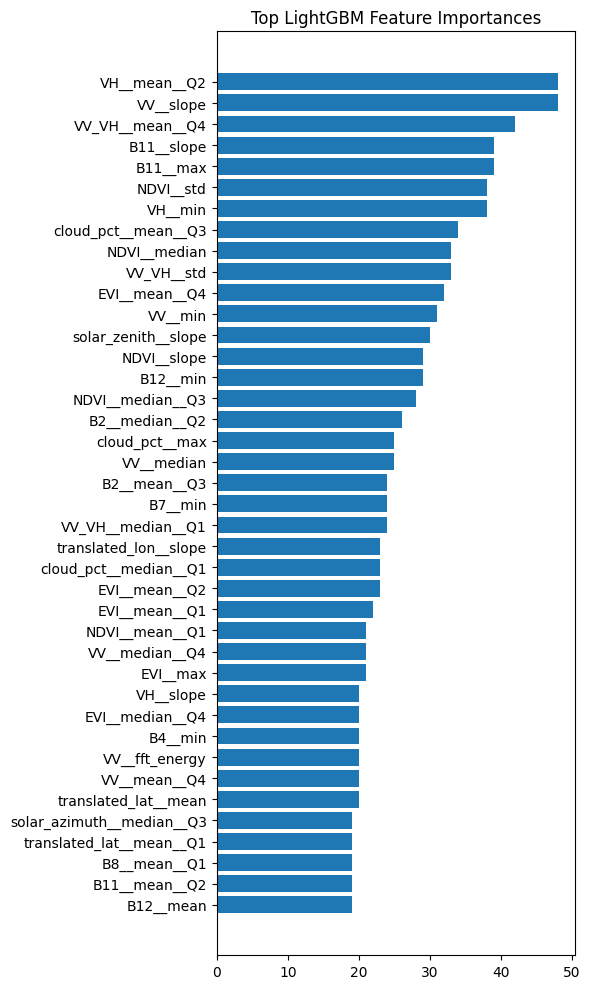

,feature,importance
31,VH__mean__Q2,48
79,VV__slope,48
49,VV_VH__mean__Q4,42
291,B11__slope,39
99,B11__max,39
162,NDVI__std,38
2,VH__min,38
269,cloud_pct__mean__Q3,34
165,NDVI__median,33
26,VV_VH__std,33


In [51]:

#@title 🔍 LightGBM Feature Importance
importances = lgbm_full.feature_importance()
features_list = [c for c in X_train.columns if c not in ["ID","id", TARGET_COL]]
fi = pd.DataFrame({"feature": features_list, "importance": importances}).sort_values("importance", ascending=False).head(40)
plt.figure(figsize=(6,10))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Top LightGBM Feature Importances")
plt.tight_layout()
plt.show()
fi.head(15)
